In [13]:
# 1. Install dependencies
!pip install -q tensorflow opencv-python matplotlib scikit-learn

In [33]:
 # 2️⃣ Import libraries
import os, zipfile, cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [34]:
# 3️⃣ Extract dataset safely
zip_path = "/content/archive (33).zip"
extract_path = "./plant_dataset"

if os.path.exists(zip_path):
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print("✅ Dataset extracted to:", extract_path)
    except zipfile.BadZipFile:
        print("❌ Invalid ZIP file! Please re-upload a valid dataset ZIP.")
else:
    print("❌ ZIP file not found! Upload your dataset.")


✅ Dataset extracted to: ./plant_dataset


In [35]:
# 4️⃣ Diagnose actual folder structure
print("\n🔍 Checking dataset folders...\n")
for root, dirs, files in os.walk(extract_path):
    print("📂 Directory:", root)
    print("   Subfolders:", dirs)
    print("   Files:", len(files))
    print("-" * 60)
    if len(dirs) > 0:
        main_folder = root  # likely contains class folders
        break



🔍 Checking dataset folders...

📂 Directory: ./plant_dataset
   Subfolders: ['test_crop_image', 'some_more_images', 'crop_images', 'kag2']
   Files: 1
------------------------------------------------------------


In [36]:
# 5️⃣ Auto-detect class folders
class_names = sorted([d for d in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, d))])
print("\n✅ Found classes:", class_names)



✅ Found classes: ['crop_images', 'kag2', 'some_more_images', 'test_crop_image']


In [37]:
# 6️⃣ Load and preprocess images
IMG_SIZE = 150
data, labels = [], []
label_map = {name: i for i, name in enumerate(class_names)}

for class_name in class_names:
    folder = os.path.join(main_folder, class_name)
    for fname in os.listdir(folder):
        img_path = os.path.join(folder, fname)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        data.append(img)
        labels.append(label_map[class_name])

data = np.array(data) / 255.0
labels = to_categorical(labels, num_classes=len(class_names))

print(f"✅ Loaded {len(data)} images across {len(class_names)} classes.")


✅ Loaded 51 images across 4 classes.


In [38]:
# 7️⃣ Train-test split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


In [39]:
# 8️⃣ Define CNN Architectures
def build_simple_cnn(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3,3), activation='relu')(inputs)
    x = MaxPooling2D(2,2)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs, name="SimpleCNN")

def build_vgg_style_cnn(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2,2)(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2,2)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs, name="VGGStyleCNN")

def build_deep_cnn(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(2,2)(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2,2)(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2,2)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs, name="DeepCNN")

# 9️⃣ Build and train all CNN models
models = {
    "Simple CNN": build_simple_cnn((IMG_SIZE, IMG_SIZE, 3), len(class_names)),
    "VGG-Style CNN": build_vgg_style_cnn((IMG_SIZE, IMG_SIZE, 3), len(class_names)),
    "Deep CNN": build_deep_cnn((IMG_SIZE, IMG_SIZE, 3), len(class_names))
}

results = {}
for name, model in models.items():
    print(f"\n🚀 Training {name}...")
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=32, verbose=1)
    loss, acc = model.evaluate(X_test, y_test)
    results[name] = acc * 100
    print(f"🎯 {name} Accuracy: {acc * 100:.2f}%")


🚀 Training Simple CNN...
Epoch 1/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 757ms/step - accuracy: 0.1333 - loss: 1.3622 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 2/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 5.5861e-05
Epoch 3/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 427ms/step - accuracy: 1.0000 - loss: 4.7732e-05 - val_accuracy: 1.0000 - val_loss: 3.6955e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 3.6955e-06
🎯 Simple CNN Accuracy: 100.00%

🚀 Training VGG-Style CNN...
Epoch 1/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7021 - loss: 1.2117 - val_accuracy: 1.0000 - val_loss: 0.0919
Epoch 2/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 1.0000 - loss: 0.0718 - val_accuracy: 1.0000 - val_loss: 0.0037
Epoch 3/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 1.0000 - val_loss: 2.2058e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 1.0000 - loss: 2.2058e-04
🎯 VG

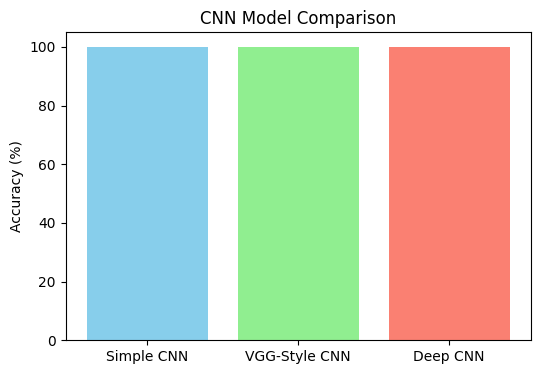

In [40]:
# 🔟 Compare model results
plt.figure(figsize=(6,4))
plt.bar(results.keys(), results.values(), color=['skyblue','lightgreen','salmon'])
plt.ylabel("Accuracy (%)")
plt.title("CNN Model Comparison")
plt.show()

In [53]:
predict_image(model, "/content/wheat0004a.jpeg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted class: test_crop_image with confidence: 98.27%


'test_crop_image'

In [55]:
# 12. Test a random image from dataset
# ======================================================
sample_image = None
for root, dirs, files in os.walk(extract_path):
    if files:
        # Find the first image file (not a CSV)
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                sample_image = os.path.join(root, file)
                break
        if sample_image:
            break

if sample_image:
    print(f"Testing with image: {sample_image}")
    predict_image(model_to_use, sample_image, class_names)
else:
    print("No image files found in the dataset.")

Testing with image: ./plant_dataset/test_crop_image/sugarcane-field.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Predicted class: test_crop_image with confidence: 99.43%


In [52]:
# Custom image prediction
custom_image_path = "/content/wheat0004a.jpeg"
predict_image(model, custom_image_path, class_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
Predicted class: test_crop_image with confidence: 98.27%


'test_crop_image'

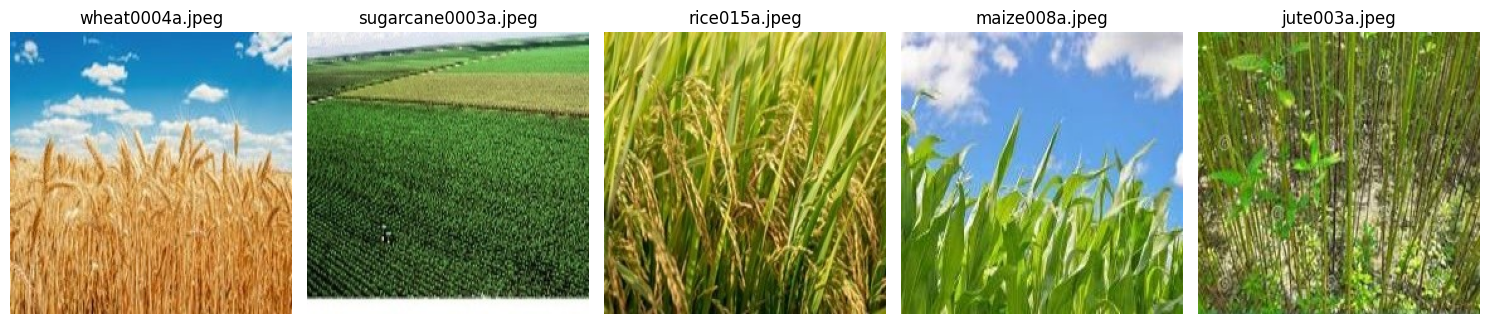

In [71]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

# 🔹 Add your image paths here
image_paths = [
    "/content/wheat0004a.jpeg",          # Wheat
    "/content/sugarcane0003a.jpeg",       # Sugarcane
    "/content/rice015a.jpeg",            # Rice
    "/content/maize008a.jpeg",           # Maize
    "/content/jute003a.jpeg"           # jute
]
# 🔹 Display all images
plt.figure(figsize=(15, 8))

for i, path in enumerate(image_paths):
    try:
        img = load_img(path)
        plt.subplot(1, len(image_paths), i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(path.split("/")[-1])
    except Exception as e:
        print(f"❌ Error loading {path}: {e}")

plt.tight_layout()
plt.show()
